Non-Negative Basis Pursuit DeNoising (APGM)
===========================================

This example demonstrates the solution of a non-negative sparse coding
problem

  $$\mathrm{argmin}_{\mathbf{x}} \; (1/2) \| \mathbf{y} - D \mathbf{x} \|_2^2
  + \lambda \| \mathbf{x} \|_1 + I(\mathbf{x} \geq 0) \;,$$

where $D$ the dictionary, $\mathbf{y}$ the signal to be represented,
$\mathbf{x}$ is the sparse representation, and $I(\mathbf{x} \geq 0)$
is the non-negative indicator.

In this example the problem is solved via Accelerated PGM, while ADMM is
used in a [companion example](sparsecode_nn_admm.rst).

In [1]:
import numpy as np

import scico.numpy as snp
from scico import functional, linop, loss, plot
from scico.optimize.pgm import AcceleratedPGM
from scico.util import device_info
plot.config_notebook_plotting()

Create random dictionary, reference random sparse representation, and
test signal consisting of the synthesis of the reference sparse
representation.

In [2]:
m = 32  # signal size
n = 128  # dictionary size
s = 10  # sparsity level

np.random.seed(1)
D = np.random.randn(m, n).astype(np.float32)
D = D / np.linalg.norm(D, axis=0, keepdims=True)  # normalize dictionary
L0 = np.linalg.norm(D, 2) ** 2

xt = np.zeros(n, dtype=np.float32)  # true signal
idx = np.random.randint(low=0, high=n, size=s)  # support of xt
xt[idx] = np.random.rand(s)
y = D @ xt + 5e-2 * np.random.randn(m)  # synthetic signal

xt = snp.array(xt)  # convert to jax array
y = snp.array(y)  # convert to jax array

Set up the forward operator and APGM solver object.

In [3]:
lmbda = 1e-1
A = linop.MatrixOperator(D)
f = loss.SquaredL2Loss(y=y, A=A)
g = functional.ProximalAverage([lmbda * functional.L1Norm(), functional.NonNegativeIndicator()])
maxiter = 250  # number of APGM iterations
solver = AcceleratedPGM(
    f=f, g=g, L0=L0, x0=A.adj(y), maxiter=maxiter, itstat_options={"display": True, "period": 10}
)

Run the solver.

In [4]:
print(f"Solving on {device_info()}\n")
x = solver.solve()

Solving on CPU



Iter  Time      Objective  L          Residual 
-----------------------------------------------
   0  1.73e-01        inf  8.262e+00  3.118e+00
  10  4.92e-01        inf  8.262e+00  1.618e-02


  20  6.22e-01        inf  8.262e+00  8.940e-03


  30  7.56e-01        inf  8.262e+00  5.616e-03
  40  8.92e-01        inf  8.262e+00  3.095e-03


  50  1.03e+00        inf  8.262e+00  1.186e-03


  60  1.24e+00        inf  8.262e+00  5.993e-04
  70  1.38e+00        inf  8.262e+00  5.112e-04


  80  1.52e+00        inf  8.262e+00  2.895e-04


  90  1.65e+00        inf  8.262e+00  1.835e-04
 100  1.79e+00        inf  8.262e+00  1.760e-04


 110  1.94e+00        inf  8.262e+00  1.271e-04


 120  2.08e+00        inf  8.262e+00  7.030e-05
 130  2.22e+00        inf  8.262e+00  6.952e-05


 140  2.36e+00        inf  8.262e+00  7.144e-05


 150  2.50e+00        inf  8.262e+00  2.630e-05
 160  2.64e+00        inf  8.262e+00  4.285e-05


 170  2.78e+00        inf  8.262e+00  4.052e-05


 180  2.92e+00        inf  8.262e+00  1.996e-05
 190  3.07e+00        inf  8.262e+00  2.255e-05


 200  3.21e+00        inf  8.262e+00  2.841e-05


 210  3.36e+00        inf  8.262e+00  1.069e-05


 220  3.50e+00        inf  8.262e+00  1.509e-05
 230  3.64e+00        inf  8.262e+00  1.857e-05


 240  3.79e+00        inf  8.262e+00  8.903e-06


 249  3.92e+00        inf  8.262e+00  8.816e-06


Plot the recovered coefficients and signal.

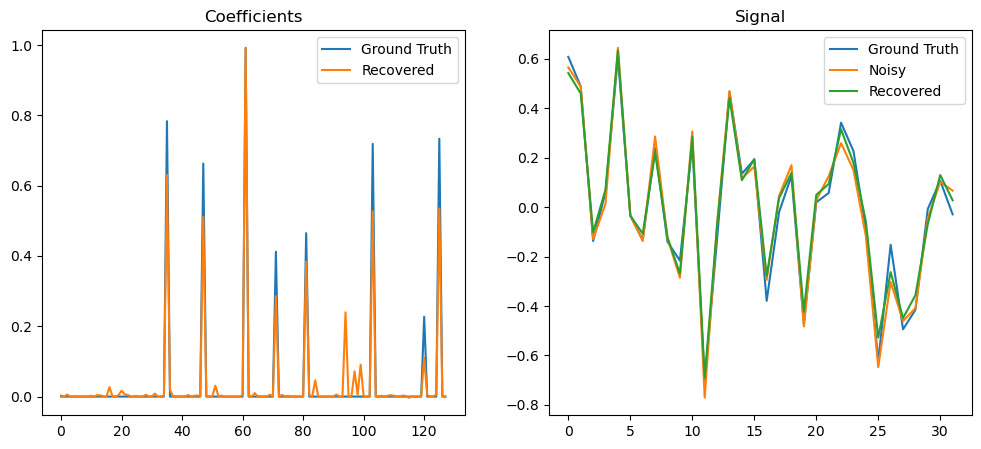

In [5]:
fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(12, 5))
plot.plot(
    np.vstack((xt, solver.x)).T,
    title="Coefficients",
    lgnd=("Ground Truth", "Recovered"),
    fig=fig,
    ax=ax[0],
)
plot.plot(
    np.vstack((D @ xt, y, D @ solver.x)).T,
    title="Signal",
    lgnd=("Ground Truth", "Noisy", "Recovered"),
    fig=fig,
    ax=ax[1],
)
fig.show()